In [749]:
# Read libraries

# Data wrangling
import pandas as pd
import numpy as np
import re
import pycountry
from shapely import wkt
import fiona
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Visualization 
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import geopandas as gpd

# Machine learning 
from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

Feature Engineering: Consider whether there are additional features you can create from your existing data that might be predictive of your outcome variable. This could include interaction terms, polynomial features, or domain-specific transformations.

Textual or Date Features: If you have text data or date-time features, there are specific preprocessing steps you could consider for these.

Data Leakage: Ensure there's no data leakage between your training and test sets. This can happen if there's information in the training data that wouldn't be available at the time of prediction when you're using your model in the real world.

Remember that preprocessing is a crucial part of the machine le

1. Read in the HFI data

In [750]:
df_2022 = pd.read_csv('/Users/albertcortbanke/Downloads/thesis_missing_data_2023/hfi/hfi_cc_2022.csv')

2. Read in the GeoJSON data

In [751]:
countries_gpd = gpd.read_file('/Users/albertcortbanke/Downloads/thesis_missing_data_2023/country_geometry_json/world-administrative-boundaries.shp')

3. Read in the Global South/North data

In [752]:
global_sn = pd.read_csv('/Users/albertcortbanke/Downloads/thesis_missing_data_2023/global_south_north/global_s_n.csv')

Check that the data has been loaded correctly

In [753]:
df_2022.head()

,year,countries,region,hf_score,hf_rank,hf_quartile,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,pf_rol_vdem,...,ef_regulation_business_adm,ef_regulation_business_burden,ef_regulation_business_start,ef_regulation_business_impartial,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,ef_score,ef_rank
0,2020,Albania,Eastern Europe,7.67,47.0,2.0,5.903741,4.725831,4.047825,7.194198,...,5.651538,6.000000,9.742477,5.9975,5.621940,7.175250,6.698118,7.112958,7.64,26.0
1,2020,Algeria,Middle East & North Africa,5.13,154.0,4.0,4.913311,5.503872,4.254187,5.461189,...,4.215154,2.222222,9.305002,2.5775,8.771111,7.029528,5.686753,5.778953,5.12,157.0
2,2020,Angola,Sub-Saharan Africa,5.97,122.0,3.0,2.773262,4.352009,3.478950,5.306695,...,2.937894,3.111111,8.730805,4.7025,7.916416,6.782923,5.696942,6.227545,5.91,138.0
3,2020,Argentina,Latin America & the Caribbean,6.99,74.0,2.0,6.824288,5.679943,4.218635,6.748978,...,2.714233,5.555556,9.579288,7.2675,5.726521,6.508295,6.225232,5.490538,4.87,161.0
4,2020,Armenia,Caucasus & Central Asia,8.14,26.0,1.0,NaN,NaN,NaN,7.204175,...,5.170406,5.111111,9.863530,6.2600,9.302574,7.040738,7.124727,7.756333,7.84,11.0


In [754]:
countries_gpd.head()

,iso3,status,color_code,name,continent,region,iso_3166_1_,french_shor,geometry
0,MNP,US Territory,USA,Northern Mariana Islands,Oceania,Micronesia,MP,Northern Mariana Islands,"MULTIPOLYGON (((145.63331 14.91236, 145.62412 ..."
1,None,Sovereignty unsettled,RUS,Kuril Islands,Asia,Eastern Asia,None,Kuril Islands,"MULTIPOLYGON (((146.68274 43.70777, 146.66664 ..."
2,FRA,Member State,FRA,France,Europe,Western Europe,FR,France,"MULTIPOLYGON (((9.44750 42.68305, 9.45014 42.6..."
3,SRB,Member State,SRB,Serbia,Europe,Southern Europe,RS,Serbie,"POLYGON ((20.26102 46.11485, 20.31403 46.06986..."
4,URY,Member State,URY,Uruguay,Americas,South America,UY,Uruguay,"POLYGON ((-53.37430 -33.74067, -53.39917 -33.7..."


In [755]:
global_sn.head()

,place,pop2023,growthRate,area,country,cca3,cca2,ccn3,region,subregion,landAreaKm,density,densityMi,Rank,globalNorth,rank
0,356,1.428628e+09,0.00808,3287590.0,India,IND,IN,356,Asia,"Southern Asia, South Central Asia",2973190.0,480.5033,1244.5036,1,False,62
1,156,1.425671e+09,-0.00015,9706961.0,China,CHN,CN,156,Asia,Eastern Asia,9424702.9,151.2696,391.7884,2,False,63
2,360,2.775341e+08,0.00738,1904569.0,Indonesia,IDN,ID,360,Asia,South-Eastern Asia,1877519.0,147.8196,382.8528,4,False,64
3,586,2.404857e+08,0.01976,881912.0,Pakistan,PAK,PK,586,Asia,"Southern Asia, South Central Asia",770880.0,311.9625,807.9829,5,False,65
4,566,2.238046e+08,0.02408,923768.0,Nigeria,NGA,NG,566,Africa,"Western Africa, Sub-Saharan Africa",910770.0,245.7312,636.4439,6,False,66


All three data frames has been loaded correctly. Now some wrangling before a merger of attributes onto the HFI-frame (df_2022)

In [756]:
# Extract the columns of interest (CCA3 for merge)
global_sn = global_sn[['cca3', 'globalNorth']]

# Remap the True/False to 1/0
global_sn['globalNorth'] = global_sn['globalNorth'].map({True: 1, False: 0})

# Rename the cca3 column to country_code for merge purposes later on
global_sn = global_sn.rename(columns={'cca3': 'country_code'})

# Check it worked
global_sn

,country_code,globalNorth
0,IND,0
1,CHN,0
2,IDN,0
3,PAK,0
4,NGA,0
...,...,...
190,MCO,1
191,SMR,1
192,PLW,1
193,TUV,1


What can the Human Freedom Score measure, and more importantly, what is it unable to measure?
What attributes are the most important to explore missingness within? (I.e what attributes correlate highly, and would be pointless to measure within)

Spatial, and temporal missingness. How do we address this with spatial models and temporal accountance?


## Merging of geometries, global south/north and HFI data frame

3. Creating a mapping function to convert country names to their corresponding ISO 3166-1 alpha-3 country codes:

In [757]:
def get_country_code(country_name):
    # Handle exceptions directly
    exception_mapping = {
        'Democratic Republic of the Congo': 'COD',
        'The Bahamas': 'BHS',
        'Ivory Coast': 'CIV',
        'Iran': 'IRN',
        'Laos': 'LAO',
        'Russia': 'RUS'
    }
    
    if country_name in exception_mapping:
        return exception_mapping[country_name]
    
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except Exception:
        return None


In [758]:
# Extra mapping for codes that are fuzzy matching

country_name_mapping = {
    'Bahamas, The': 'The Bahamas',
    'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
    'Congo, Rep.': 'Republic of the Congo',
    "Cote d'Ivoire": 'Ivory Coast',
    'Egypt, Arab Rep.': 'Egypt',
    'Gambia, The': 'Gambia',
    'Hong Kong SAR, China': 'Hong Kong',
    'Iran, Islamic Rep.': 'Iran',
    'Korea, Rep.': 'South Korea',
    'Lao PDR': 'Laos',
    'Venezuela, RB': 'Venezuela',
    'Yemen, Rep.': 'Yemen'
}

In [759]:
# Use the fuzzy matching to begin with
df_2022['countries'] = df_2022['countries'].replace(country_name_mapping)

# Create a new column with the correct ISO-country codes using the get_country_code function
df_2022['country_code'] = df_2022['countries'].apply(get_country_code)

In [760]:
# Renaming the iso3 column to country_code in the countries_gpd df for easier matching
countries_gpd = countries_gpd.rename(columns={"iso3": "country_code"})

In [761]:
# Select only the 'country_code' and 'geometry' columns from the GeoPandas DataFrame
countries_gpd_filtered = countries_gpd[['country_code', 'geometry']]

# Merge the DataFrames on the 'country_code' column
sample_merged = df_2022.merge(countries_gpd_filtered, on='country_code', how='left')

# Merge the Dataframe, again, on the 'country_code' column to get the global_north attribute
merged_gdf = sample_merged.merge(global_sn, on='country_code', how='left')

# Convert the merged DataFrame to a GeoDataFrame, using the 'geometry' column as the geometry
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')

In [762]:
# Check if there are non-matched values for the geometries/polygons
merged_gdf.geometry.isnull().value_counts()

False    3486
Name: geometry, dtype: int64

In [763]:
# Check if there are non-matched values for the globalNorth
merged_gdf.globalNorth.isnull().value_counts()

False    3444
True       42
Name: globalNorth, dtype: int64

In [764]:
# After further inspection of the above information and DF, Taiwan and Hong Kong needs to mapped manually 
merged_gdf.loc[merged_gdf['country_code'] == 'HKG', 'globalNorth'] = 1.0
merged_gdf.loc[merged_gdf['country_code'] == 'TWN', 'globalNorth'] = 1.0

In [765]:
# Save the DataFrame, non-processed, as a Parquet file
gdf_nonproc = gpd.GeoDataFrame(merged_gdf, geometry='geometry')

# Save the GeoDataFrame as a GeoParquet file
gdf_nonproc.to_parquet('gdf_nonproc.parquet', compression='snappy', index=False)

## Feature selection (mulitcollinarity & VIF)

<AxesSubplot:>

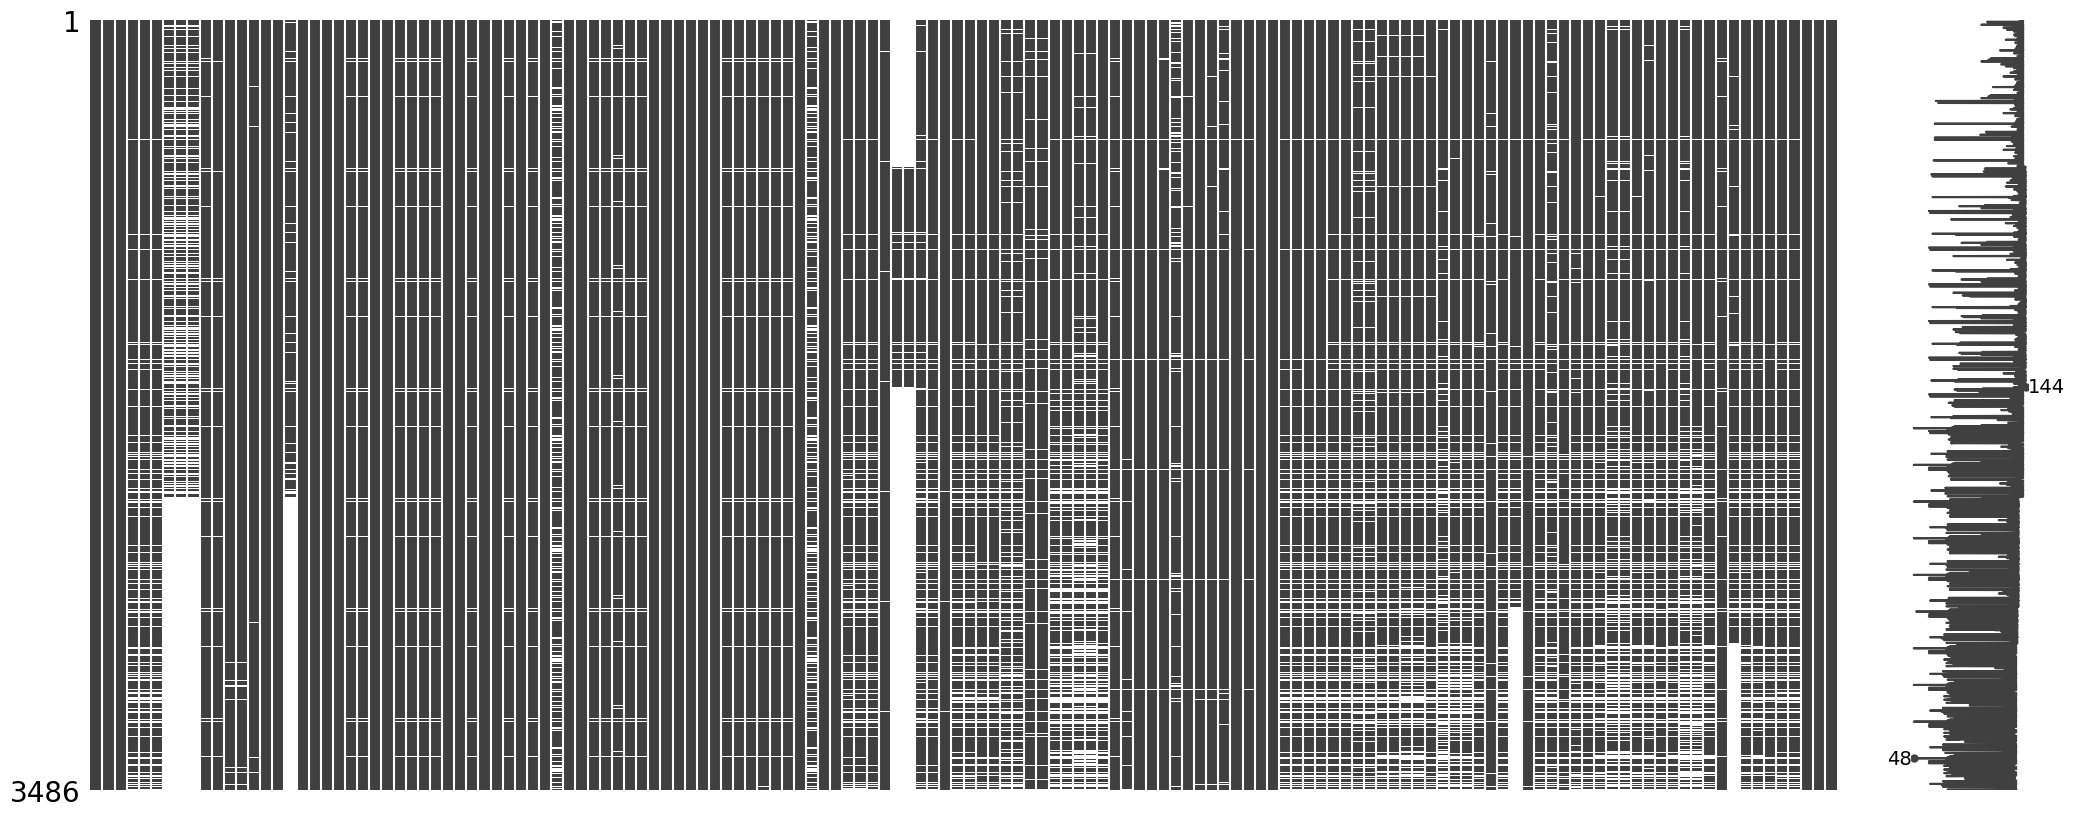

In [766]:
# Create a missingness matrix to get an overview of the patterns of missingness in the features and rows
msno.matrix(merged_gdf)

In [767]:
df_copy = merged_gdf.isna().sum()

df_copy = pd.DataFrame(df_copy, columns=['na_count'])

In [768]:
df_copy.sort_values(by='na_count', ascending=False).head(60)# Calculate the percentage of missing values for each column
missing_percent = merged_gdf.isnull().mean() * 100

# Create a DataFrame to display the results
missing_percent_df = pd.DataFrame({'Column': missing_percent.index, 'Missing (%)': missing_percent.values})

# Sort the DataFrame by the percentage of missing values in descending order
missing_percent_df = missing_percent_df.sort_values(by='Missing (%)', ascending=False)

# Display the DataFrame
missing_percent_df.head(35)

,Column,Missing (%)
67,pf_identity_inheritance_daughters,73.522662
66,pf_identity_inheritance_widows,73.522662
8,pf_rol_criminal,59.753299
6,pf_rol_procedural,59.753299
7,pf_rol_civil,59.753299
16,pf_ss_disappearances_organized,43.086632
117,ef_trade_movement_visit,28.829604
59,pf_expression_bti,28.427998
38,pf_assembly_freedom_bti,28.427998
135,ef_regulation_business_licensing,26.907631


## Selected outcome attributes

pf_expression
ef_score
pf_role_civil
hf_score

In [769]:
# Create a subset with all attributes except for the potential outcome-variables
df_attributes = merged_gdf.drop(columns=['ef_score','hf_score','pf_expression_bti', 'pf_rol_civil'])

In [770]:
df_attributes.pf_ss_disappearances_violent.describe()

count     3486.000000
mean        75.381727
std        497.217838
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max      13075.990000
Name: pf_ss_disappearances_fatalities_data, dtype: float64

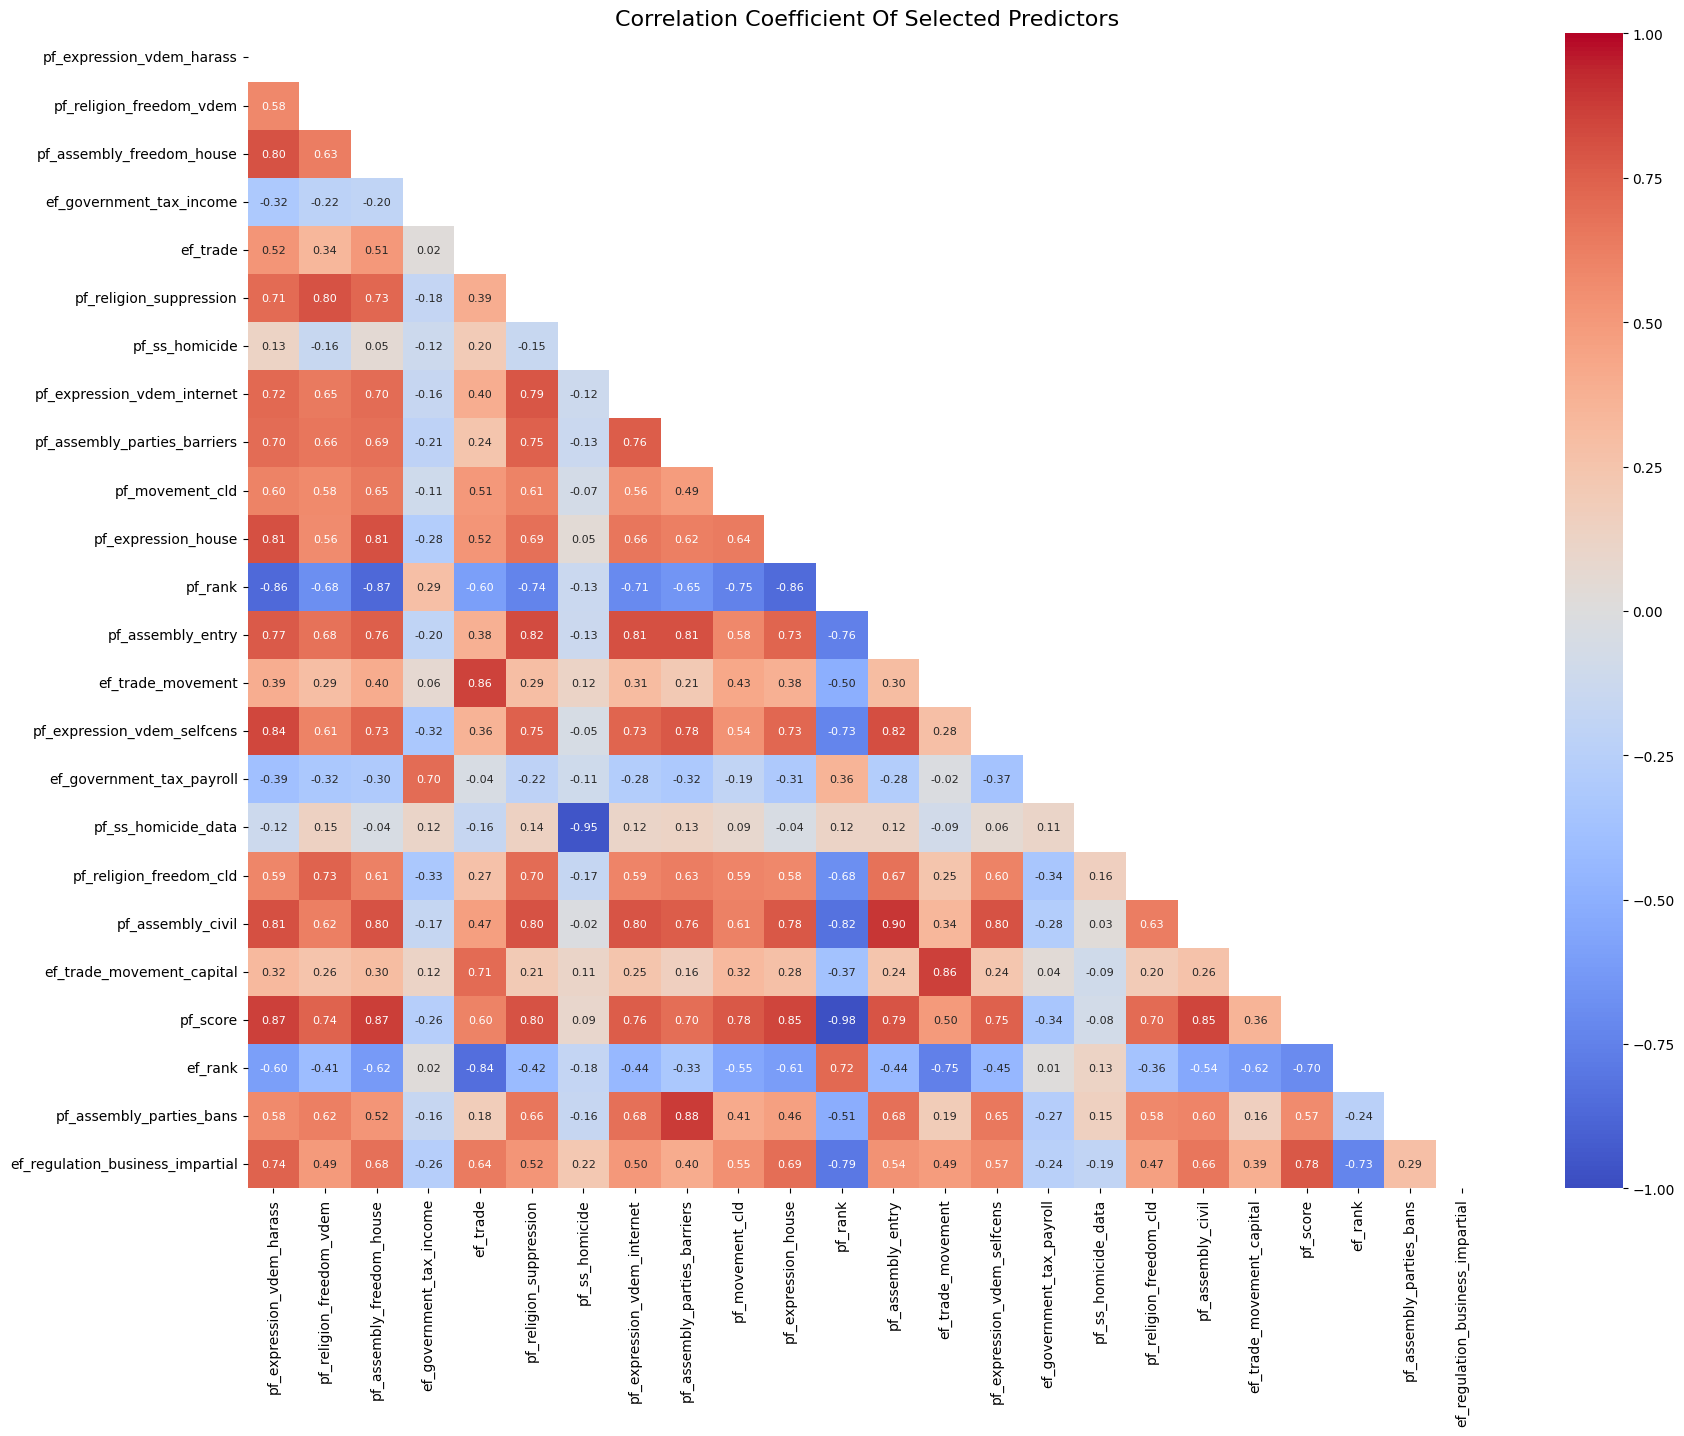

In [771]:
# Set correlation threshold
corr_threshold = 0.7

# A selected subset to visualize (as there are over 100's of attributes not all are showcased visually)
selected_columns = [
    'pf_expression_vdem_harass',
    'pf_religion_freedom_vdem',
    'pf_assembly_freedom_house',
    'ef_government_tax_income',
    'ef_trade',
    'pf_religion_suppression',
    'pf_ss_homicide',
    'pf_expression_vdem_internet',
    'pf_assembly_parties_barriers',
    'pf_movement_cld',
    'pf_expression_house',
    'pf_rank',
    'pf_assembly_entry',
    'ef_trade_movement',
    'pf_expression_vdem_selfcens',
    'ef_government_tax_payroll',
    'pf_ss_homicide_data',
    'pf_religion_freedom_cld',
    'pf_assembly_civil',
    'ef_trade_movement_capital',
    'pf_score',
    'ef_rank',
    'pf_assembly_parties_bans',
    'ef_regulation_business_impartial'
]

df_selected = df_attributes[selected_columns]

# Set figure size
plt.figure(figsize=(20, 15))

# Generate a mask to only show the lower triangle
mask = np.triu(np.ones_like(df_selected.corr(), dtype=bool))

# Generate heatmap
sns.heatmap(df_selected.corr(), annot=True, mask=mask, vmin=-1, vmax=1, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})

# Rotate x-axis tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Correlation Coefficient Of Selected Predictors', fontsize=16)
plt.show()

In [772]:
# Get correlation matrix
corr_matrix = df_attributes.corr()

# Extract features with high correlations
high_correlation_features = set()
for col in corr_matrix.columns:
    for row in corr_matrix.index:
        if col != row and abs(corr_matrix.loc[col, row]) > 0.70:
            high_correlation_features.add(col)
            high_correlation_features.add(row)

# Convert the set to a list
high_correlation_features = list(high_correlation_features)

# Print the list of features
print("Features with high correlations:")
for feature in high_correlation_features:
    print(feature)

Features with high correlations:
pf_assembly_freedom
ef_money_currency
ef_trade_tariffs_mean_data
pf_ss_disappearances_fatalities_data
pf_score
pf_rank
pf_identity_divorce
pf_movement_vdem_men
pf_rol_procedural
hf_quartile
ef_government_tax
pf_identity_inheritance_widows
pf_movement_vdem_women
pf_assembly_civil
pf_ss_disappearances_injuries_data
ef_trade_tariffs_mean
ef_government_tax_income
ef_regulation_business_burden
pf_movement
ef_government_transfers_data
pf_movement_vdem_foreign
pf_expression_vdem_gov
ef_government_consumption_data
pf_identity_inheritance_daughters
ef_trade_tariffs_sd
pf_ss_homicide
ef_trade
pf_movement_vdem
pf_religion_suppression
ef_legal_courts
pf_assembly
ef_government_transfers
ef_legal
pf_expression_vdem_cultural
ef_money_growth
ef_government_investment
pf_movement_cld
pf_identity_same_f
ef_regulation_business
pf_ss_disappearances_fatalities
ef_government_soa
ef_trade_regulatory
pf_assembly_parties_bans
globalNorth
pf_assembly_parties_barriers
pf_expressio

In [773]:
# Create a VIF-function to remove high VIF-features sequentially

def find_high_vif_features(df, considered_features, vif_threshold=10):
    X = df[considered_features].copy()
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.dropna(inplace=True)

    # Add a constant for the VIF calculation
    X['intercept'] = 1

    # Calculate VIF values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Add features with infinite VIF values to high_vif_features list
    inf_vif_features = vif[vif['VIF'] == float('inf')]['Variable'].tolist()
    high_vif_features = inf_vif_features.copy()

    # Remove features with infinite VIF values from VIF DataFrame
    if inf_vif_features:
        print(f"Removing features with infinite VIF values: {', '.join(inf_vif_features)}")
        vif = vif[vif['VIF'] != float('inf')]
        considered_features = list(set(considered_features) - set(inf_vif_features))

    # Iteratively remove features with VIF values above the threshold
    while (vif['VIF'] > vif_threshold).any():
        max_vif_feature = vif.loc[vif['VIF'].idxmax()]['Variable']
        high_vif_features.append(max_vif_feature)
        print(f"Removing {max_vif_feature} with VIF = {vif.loc[vif['VIF'].idxmax()]['VIF']}")
        vif = vif[vif['Variable'] != max_vif_feature]
        considered_features.remove(max_vif_feature)

    return high_vif_features

# Set a VIF threshold
vif_threshold = 10

# Features to consider removing
considered_features = high_correlation_features

# Find features with high VIF
high_vif_features = find_high_vif_features(df_attributes, considered_features, vif_threshold)

Removing features with infinite VIF values: pf_assembly_freedom, ef_trade_tariffs_mean_data, pf_movement_vdem_men, ef_government_tax, pf_identity_inheritance_widows, pf_movement_vdem_women, pf_assembly_civil, ef_trade_tariffs_mean, ef_government_tax_income, pf_movement, pf_movement_vdem_foreign, pf_expression_vdem_gov, pf_identity_inheritance_daughters, ef_trade_tariffs_sd, pf_ss_homicide, pf_movement_vdem, pf_religion_suppression, pf_assembly, pf_expression_vdem_cultural, pf_movement_cld, pf_identity_same_f, ef_regulation_business, ef_trade_regulatory, pf_assembly_parties_bans, pf_assembly_parties_barriers, pf_expression_direct_killed, pf_expression_vdem_selfcens, pf_identity_inheritance, ef_regulation, pf_assembly_freedom_house, ef_trade_movement_capital, ef_regulation_labor, ef_trade_regulatory_nontariff, pf_expression_direct, pf_ss_disappearances, pf_assembly_parties_auton, pf_religion_freedom, pf_expression_direct_jailed, pf_religion, pf_expression_vdem_internet, pf_identity_same,

In [774]:
# Remove columns with high VIF from df_attributes
df_attributes.drop(high_vif_features, axis=1, inplace=True)

In [775]:
# Convert columns to numeric, which currently has type 'Object' (non-numeric)
cols_to_convert = ['ef_government_tax_income_data', 'ef_government_tax_payroll_data', 'ef_regulation_labor_dismissal']

for col in cols_to_convert:
    df_attributes[col] = pd.to_numeric(df_attributes[col], errors='coerce')

<AxesSubplot:>

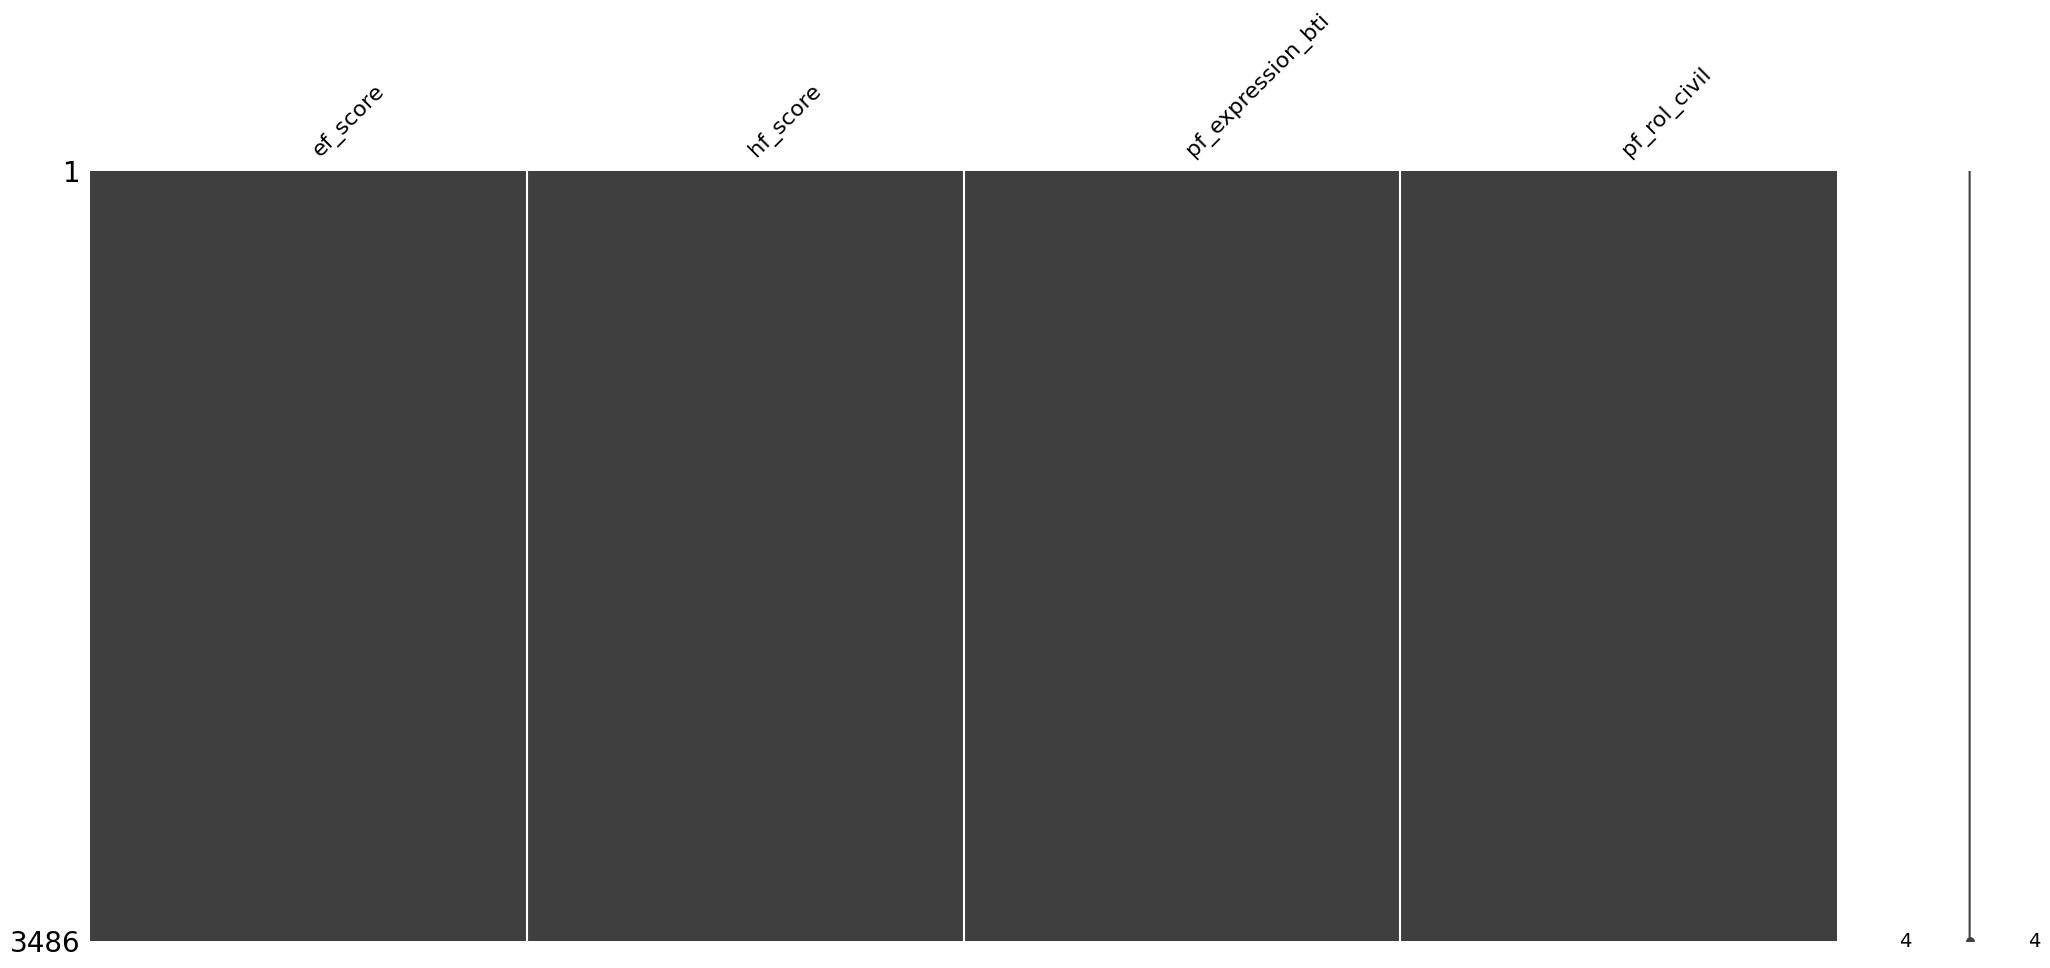

In [776]:
# Reappend the outcome-variables
df_outcome_variables = merged_gdf[['ef_score','hf_score','pf_expression_bti', 'pf_rol_civil']]

# Remap the outcome-variables to a binary 0-1 for classifying missingness
df_outcome_variables = df_outcome_variables.isna().astype(int)

# 0 for non-missing and 1 for missing
msno.matrix(df_outcome_variables)

# As seen below the attributes are now complete after the remapping

### Extract non-imputed dataframe

In [777]:
df_attribute_copy = df_attributes.copy()

In [778]:
# Concatenate the DataFrames along the columns axis
df_result_no_imput = pd.concat([df_attribute_copy, df_outcome_variables], axis=1)

In [779]:
df_result_no_imput.to_parquet('df_pure', compression='snappy', index=False)

### Impute the non-outcome variables with different imputation techniques (multiple vs spatio-temporal knn)

### Complex imputation (BayesianRidge)

In [780]:
# Setup of the imputater and its controls
#imp = IterativeImputer(max_iter=10, random_state=0)

# Exclude non-numerical columns
#numerical_cols = df_attributes.select_dtypes(include=[np.number]).columns
#df_numerical = df_attributes[numerical_cols]

# Perform multiple imputation
#df_imputed = imp.fit_transform(df_numerical)

# Convert back to dataframe
#df_imputed = pd.DataFrame(df_imputed, columns = df_numerical.columns)

# Replace the original numerical columns with the imputed ones
#df_attributes[numerical_cols] = df_imputed

### Simple imputation (linear)

In [781]:
from sklearn.impute import KNNImputer

# Exclude non-numerical columns
non_numerical_cols = df_attributes.select_dtypes(exclude=[np.number]).columns.drop('countries')
df_numerical = df_attributes.drop(columns=non_numerical_cols)

# Store the 'countries' column
country_col = df_attributes['countries']

# Check missing values before Interpolation
print("Missing values before Interpolation: ", df_numerical.isnull().sum().sum())

# Interpolate missing values along the time axis
df_interpolated = df_numerical.groupby(country_col).apply(lambda group: group.interpolate(limit_direction='both'))

# Check missing values after Interpolation and before KNN Imputation
print("Missing values after Interpolation: ", df_interpolated.isnull().sum().sum())

# Then use KNN to fill in any remaining missing values (excluding the 'countries' column)
imputer = KNNImputer(n_neighbors=6, weights="uniform")
df_imputed = imputer.fit_transform(df_interpolated.drop(columns=['countries']))

# Convert back to dataframe and preserve the original index
df_imputed = pd.DataFrame(df_imputed, columns=df_interpolated.drop(columns=['countries']).columns, index=df_interpolated.index)

# Concatenate the 'countries' column back to the imputed data
df_imputed = pd.concat([country_col, df_imputed], axis=1)

# Check for any remaining missing data
if df_imputed.isnull().sum().sum() != 0:
    print("There are still missing values in the data.")
else:
    print("No missing values after imputation")

# Replace the original numerical columns with the imputed ones
df_attributes[df_numerical.columns] = df_imputed

df_attributes.rename(columns={'year': 'countries', 'countries': 'year'}, inplace=True)

Missing values before Interpolation:  10526
Missing values after Interpolation:  651
No missing values after imputation


In [783]:
df_attributes

,countries,year,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_expression_direct_killed_data,pf_expression_direct_jailed_data,pf_identity_fgm,ef_government_tax_income_data,...,ef_regulation_labor_firing,ef_regulation_labor_bargain,ef_regulation_labor_hours,ef_regulation_labor_dismissal,ef_regulation_labor_conscription,ef_regulation_business_adm,ef_regulation_business_start,ef_regulation_business_licensing,country_code,geometry
0,Albania,2020.0,Eastern Europe,10.0,10.000000,0.0,0.0,0.0,10.0,23.0,...,4.865385,5.575783,8.000,6.299741,10.0,5.651538,9.742477,5.621940,ALB,"POLYGON ((20.07142 42.56091, 20.10208 42.53347..."
1,Algeria,2020.0,Middle East & North Africa,10.0,9.687083,25.0,0.0,8.0,10.0,35.0,...,5.028064,6.522477,6.000,7.755176,3.0,4.215154,9.305002,8.771111,DZA,"POLYGON ((8.62203 36.94137, 8.63222 36.88194, ..."
2,Angola,2020.0,Sub-Saharan Africa,10.0,9.582498,25.0,0.0,0.0,10.0,17.0,...,4.426570,6.969783,4.000,6.632764,0.0,2.937894,8.730805,7.916416,AGO,"MULTIPOLYGON (((23.98621 -10.87046, 23.98805 -..."
3,Argentina,2020.0,Latin America & the Caribbean,5.0,10.000000,0.0,0.0,0.0,10.0,35.0,...,2.240387,3.192984,10.000,2.517254,10.0,2.714233,9.579288,5.726521,ARG,"MULTIPOLYGON (((-68.64312 -54.88861, -68.63723..."
4,Armenia,2020.0,Caucasus & Central Asia,10.0,10.000000,0.0,0.0,0.0,10.0,23.0,...,5.599639,7.248644,10.000,9.251725,0.0,5.170406,9.863530,9.302574,ARM,"POLYGON ((46.54038 38.87559, 46.51639 38.87804..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,Venezuela,2000.0,Latin America & the Caribbean,10.0,10.000000,0.0,0.0,0.0,10.0,35.0,...,4.550910,5.834500,5.678,0.000000,0.0,6.417950,6.268547,4.529453,VEN,"MULTIPOLYGON (((-61.18507 8.49674, -61.19417 8..."
3482,Vietnam,2000.0,South Asia,10.0,10.000000,0.0,0.0,16.0,10.0,63.0,...,5.000000,7.166667,8.700,1.934557,0.0,3.000000,7.885638,2.755084,VNM,"MULTIPOLYGON (((104.08288 10.36486, 104.08663 ..."
3483,Yemen,2000.0,Middle East & North Africa,5.0,10.000000,0.0,0.0,0.0,10.0,15.0,...,5.608662,7.991593,8.000,2.517254,0.0,2.620223,8.735527,8.917008,YEM,"MULTIPOLYGON (((52.23416 12.20111, 52.27888 12..."
3484,Zambia,2000.0,Sub-Saharan Africa,10.0,10.000000,0.0,0.0,2.0,10.0,30.0,...,5.166667,7.166667,4.700,0.000000,10.0,3.166667,8.537578,1.776236,ZMB,"POLYGON ((32.94040 -9.40508, 32.93944 -9.41583..."


In [784]:
df_attributes.pf_ss_disappearances_violent.describe()

count    3486.000000
mean        9.218442
std         2.380573
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        10.000000
Name: pf_ss_disappearances_violent, dtype: float64

In [785]:
df_attributes

,countries,year,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_expression_direct_killed_data,pf_expression_direct_jailed_data,pf_identity_fgm,ef_government_tax_income_data,...,ef_regulation_labor_firing,ef_regulation_labor_bargain,ef_regulation_labor_hours,ef_regulation_labor_dismissal,ef_regulation_labor_conscription,ef_regulation_business_adm,ef_regulation_business_start,ef_regulation_business_licensing,country_code,geometry
0,Albania,2020.0,Eastern Europe,10.0,10.000000,0.0,0.0,0.0,10.0,23.0,...,4.865385,5.575783,8.000,6.299741,10.0,5.651538,9.742477,5.621940,ALB,"POLYGON ((20.07142 42.56091, 20.10208 42.53347..."
1,Algeria,2020.0,Middle East & North Africa,10.0,9.687083,25.0,0.0,8.0,10.0,35.0,...,5.028064,6.522477,6.000,7.755176,3.0,4.215154,9.305002,8.771111,DZA,"POLYGON ((8.62203 36.94137, 8.63222 36.88194, ..."
2,Angola,2020.0,Sub-Saharan Africa,10.0,9.582498,25.0,0.0,0.0,10.0,17.0,...,4.426570,6.969783,4.000,6.632764,0.0,2.937894,8.730805,7.916416,AGO,"MULTIPOLYGON (((23.98621 -10.87046, 23.98805 -..."
3,Argentina,2020.0,Latin America & the Caribbean,5.0,10.000000,0.0,0.0,0.0,10.0,35.0,...,2.240387,3.192984,10.000,2.517254,10.0,2.714233,9.579288,5.726521,ARG,"MULTIPOLYGON (((-68.64312 -54.88861, -68.63723..."
4,Armenia,2020.0,Caucasus & Central Asia,10.0,10.000000,0.0,0.0,0.0,10.0,23.0,...,5.599639,7.248644,10.000,9.251725,0.0,5.170406,9.863530,9.302574,ARM,"POLYGON ((46.54038 38.87559, 46.51639 38.87804..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,Venezuela,2000.0,Latin America & the Caribbean,10.0,10.000000,0.0,0.0,0.0,10.0,35.0,...,4.550910,5.834500,5.678,0.000000,0.0,6.417950,6.268547,4.529453,VEN,"MULTIPOLYGON (((-61.18507 8.49674, -61.19417 8..."
3482,Vietnam,2000.0,South Asia,10.0,10.000000,0.0,0.0,16.0,10.0,63.0,...,5.000000,7.166667,8.700,1.934557,0.0,3.000000,7.885638,2.755084,VNM,"MULTIPOLYGON (((104.08288 10.36486, 104.08663 ..."
3483,Yemen,2000.0,Middle East & North Africa,5.0,10.000000,0.0,0.0,0.0,10.0,15.0,...,5.608662,7.991593,8.000,2.517254,0.0,2.620223,8.735527,8.917008,YEM,"MULTIPOLYGON (((52.23416 12.20111, 52.27888 12..."
3484,Zambia,2000.0,Sub-Saharan Africa,10.0,10.000000,0.0,0.0,2.0,10.0,30.0,...,5.166667,7.166667,4.700,0.000000,10.0,3.166667,8.537578,1.776236,ZMB,"POLYGON ((32.94040 -9.40508, 32.93944 -9.41583..."


<AxesSubplot:>

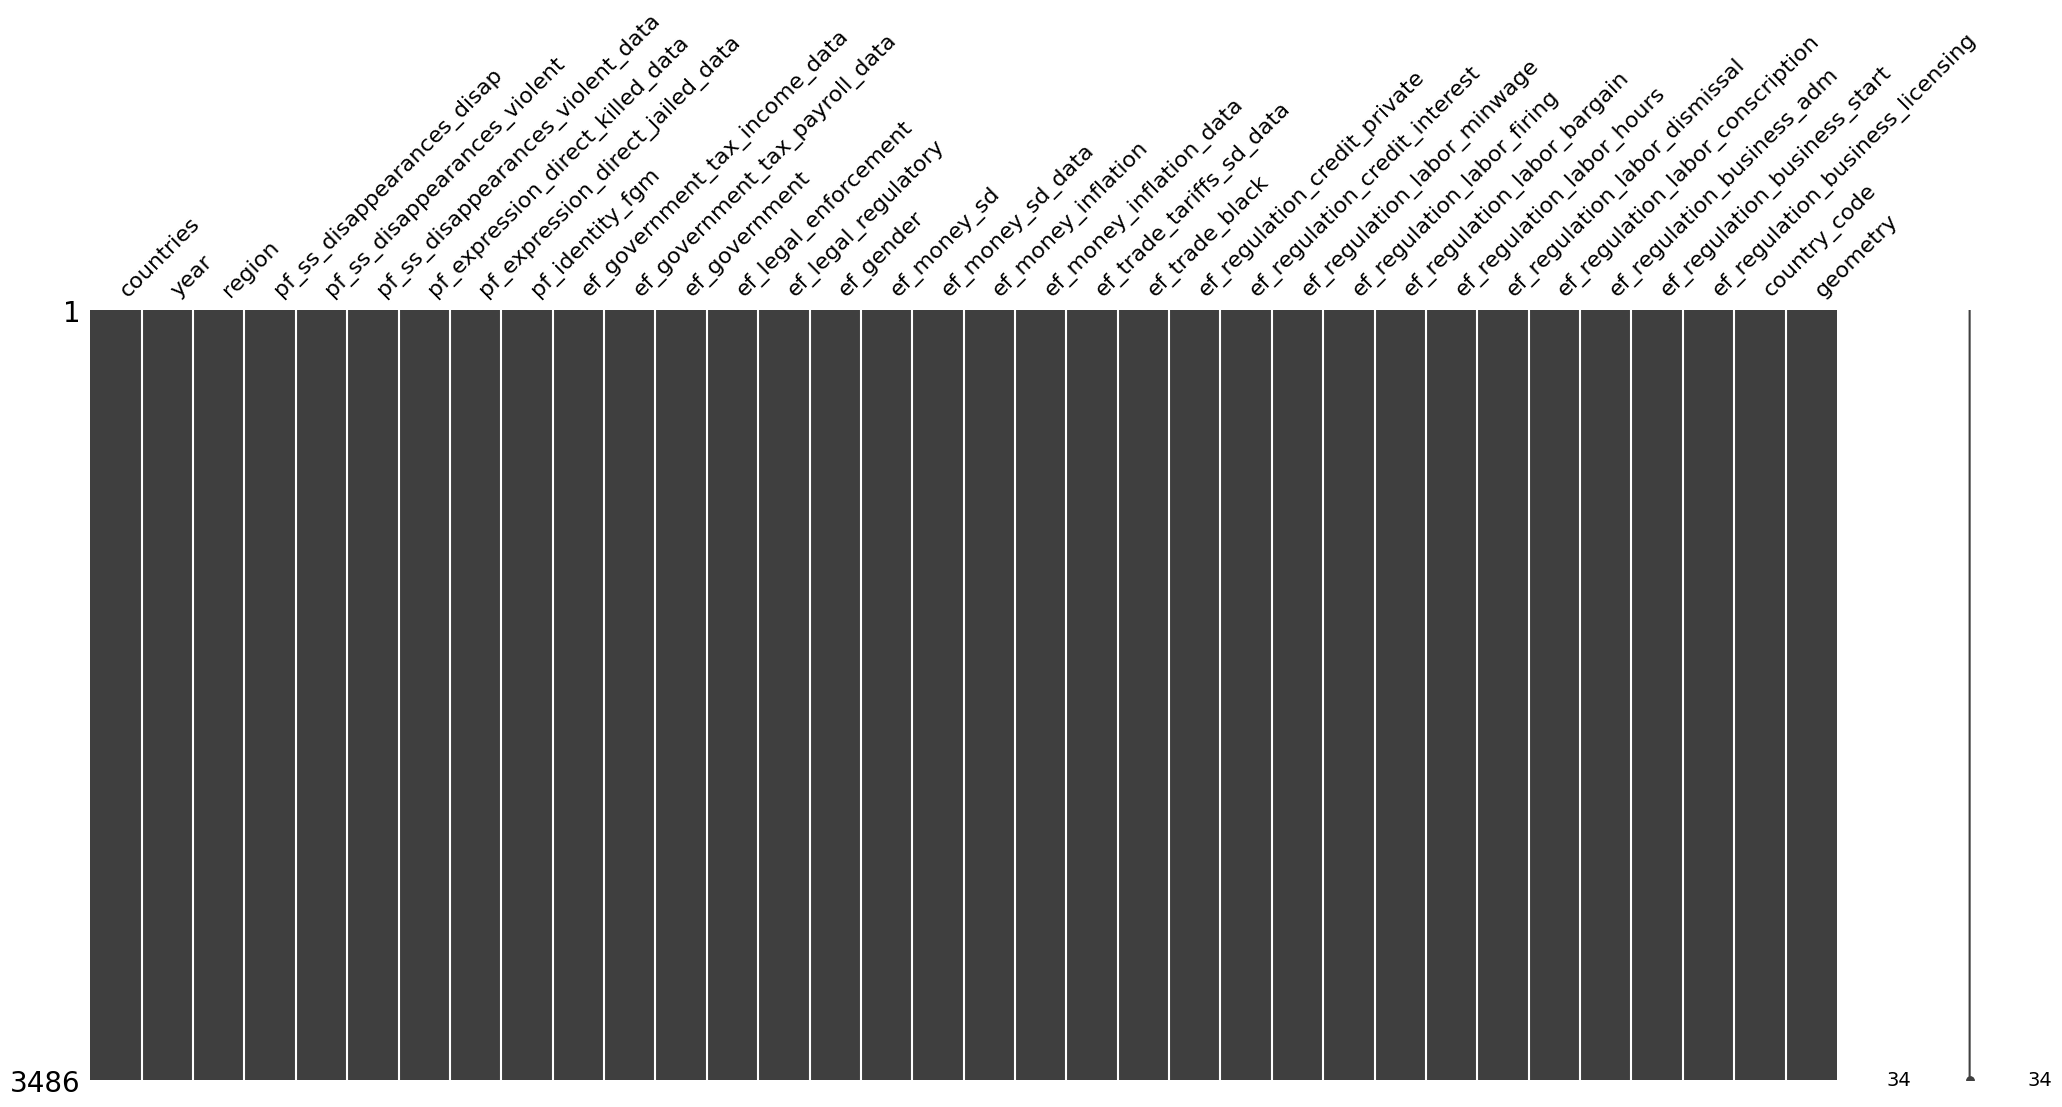

In [786]:
# Check for completeness after imputation
msno.matrix(df_attributes)

In [787]:
df_attributes.describe()

,year,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_expression_direct_killed_data,pf_expression_direct_jailed_data,pf_identity_fgm,ef_government_tax_income_data,ef_government_tax_payroll_data,ef_government,...,ef_regulation_credit_interest,ef_regulation_labor_minwage,ef_regulation_labor_firing,ef_regulation_labor_bargain,ef_regulation_labor_hours,ef_regulation_labor_dismissal,ef_regulation_labor_conscription,ef_regulation_business_adm,ef_regulation_business_start,ef_regulation_business_licensing
count,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,...,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000,3486.000000
mean,2010.000000,8.454532,9.218442,214.990964,1.814974,4.037866,9.097193,30.501524,39.534785,6.625386,...,9.008797,6.404378,4.324742,5.966258,7.701518,6.229513,6.437751,3.591915,8.479575,7.416510
std,6.056169,3.098342,2.380573,2130.057043,7.665901,19.998572,2.260352,13.784179,13.122652,1.332380,...,1.819966,2.776120,1.798095,2.213964,1.960568,3.014081,4.255606,1.661213,1.569708,2.023394
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.117808,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005.000000,10.000000,10.000000,0.000000,0.000000,0.000000,9.500000,22.000000,32.000000,5.849607,...,9.000000,4.400000,3.551016,5.469084,6.000000,4.128922,3.000000,2.759307,7.987419,6.621080
50%,2010.000000,10.000000,10.000000,0.000000,0.000000,0.000000,10.000000,31.000000,40.000000,6.740232,...,10.000000,6.666667,4.574566,6.601901,8.000000,7.033400,10.000000,3.621227,9.005358,7.947234
75%,2015.000000,10.000000,10.000000,0.000000,1.000000,1.000000,10.000000,40.000000,48.000000,7.564811,...,10.000000,8.900000,5.448329,7.403575,10.000000,8.423994,10.000000,4.597299,9.575382,8.916562
max,2020.000000,10.000000,10.000000,69089.000000,127.000000,310.000000,10.000000,65.000000,70.800000,9.351745,...,10.000000,10.000000,8.801760,9.500000,10.000000,10.000000,10.000000,8.535040,9.981891,10.000000


In [788]:
# Check how it looks in terms of numbers
df_outcome_variables

,ef_score,hf_score,pf_expression_bti,pf_rol_civil
0,0,0,0,0
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,1
...,...,...,...,...
3481,0,0,0,1
3482,0,0,0,1
3483,1,1,0,1
3484,0,0,0,1


In [789]:
# Concatenate the DataFrames along the columns axis
df_result = pd.concat([df_attributes, df_outcome_variables], axis=1)

In [790]:
df_result

,countries,year,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_expression_direct_killed_data,pf_expression_direct_jailed_data,pf_identity_fgm,ef_government_tax_income_data,...,ef_regulation_labor_conscription,ef_regulation_business_adm,ef_regulation_business_start,ef_regulation_business_licensing,country_code,geometry,ef_score,hf_score,pf_expression_bti,pf_rol_civil
0,Albania,2020.0,Eastern Europe,10.0,10.000000,0.0,0.0,0.0,10.0,23.0,...,10.0,5.651538,9.742477,5.621940,ALB,"POLYGON ((20.07142 42.56091, 20.10208 42.53347...",0,0,0,0
1,Algeria,2020.0,Middle East & North Africa,10.0,9.687083,25.0,0.0,8.0,10.0,35.0,...,3.0,4.215154,9.305002,8.771111,DZA,"POLYGON ((8.62203 36.94137, 8.63222 36.88194, ...",0,0,0,0
2,Angola,2020.0,Sub-Saharan Africa,10.0,9.582498,25.0,0.0,0.0,10.0,17.0,...,0.0,2.937894,8.730805,7.916416,AGO,"MULTIPOLYGON (((23.98621 -10.87046, 23.98805 -...",0,0,0,0
3,Argentina,2020.0,Latin America & the Caribbean,5.0,10.000000,0.0,0.0,0.0,10.0,35.0,...,10.0,2.714233,9.579288,5.726521,ARG,"MULTIPOLYGON (((-68.64312 -54.88861, -68.63723...",0,0,0,0
4,Armenia,2020.0,Caucasus & Central Asia,10.0,10.000000,0.0,0.0,0.0,10.0,23.0,...,0.0,5.170406,9.863530,9.302574,ARM,"POLYGON ((46.54038 38.87559, 46.51639 38.87804...",0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,Venezuela,2000.0,Latin America & the Caribbean,10.0,10.000000,0.0,0.0,0.0,10.0,35.0,...,0.0,6.417950,6.268547,4.529453,VEN,"MULTIPOLYGON (((-61.18507 8.49674, -61.19417 8...",0,0,0,1
3482,Vietnam,2000.0,South Asia,10.0,10.000000,0.0,0.0,16.0,10.0,63.0,...,0.0,3.000000,7.885638,2.755084,VNM,"MULTIPOLYGON (((104.08288 10.36486, 104.08663 ...",0,0,0,1
3483,Yemen,2000.0,Middle East & North Africa,5.0,10.000000,0.0,0.0,0.0,10.0,15.0,...,0.0,2.620223,8.735527,8.917008,YEM,"MULTIPOLYGON (((52.23416 12.20111, 52.27888 12...",1,1,0,1
3484,Zambia,2000.0,Sub-Saharan Africa,10.0,10.000000,0.0,0.0,2.0,10.0,30.0,...,10.0,3.166667,8.537578,1.776236,ZMB,"POLYGON ((32.94040 -9.40508, 32.93944 -9.41583...",0,0,0,1


<AxesSubplot:>

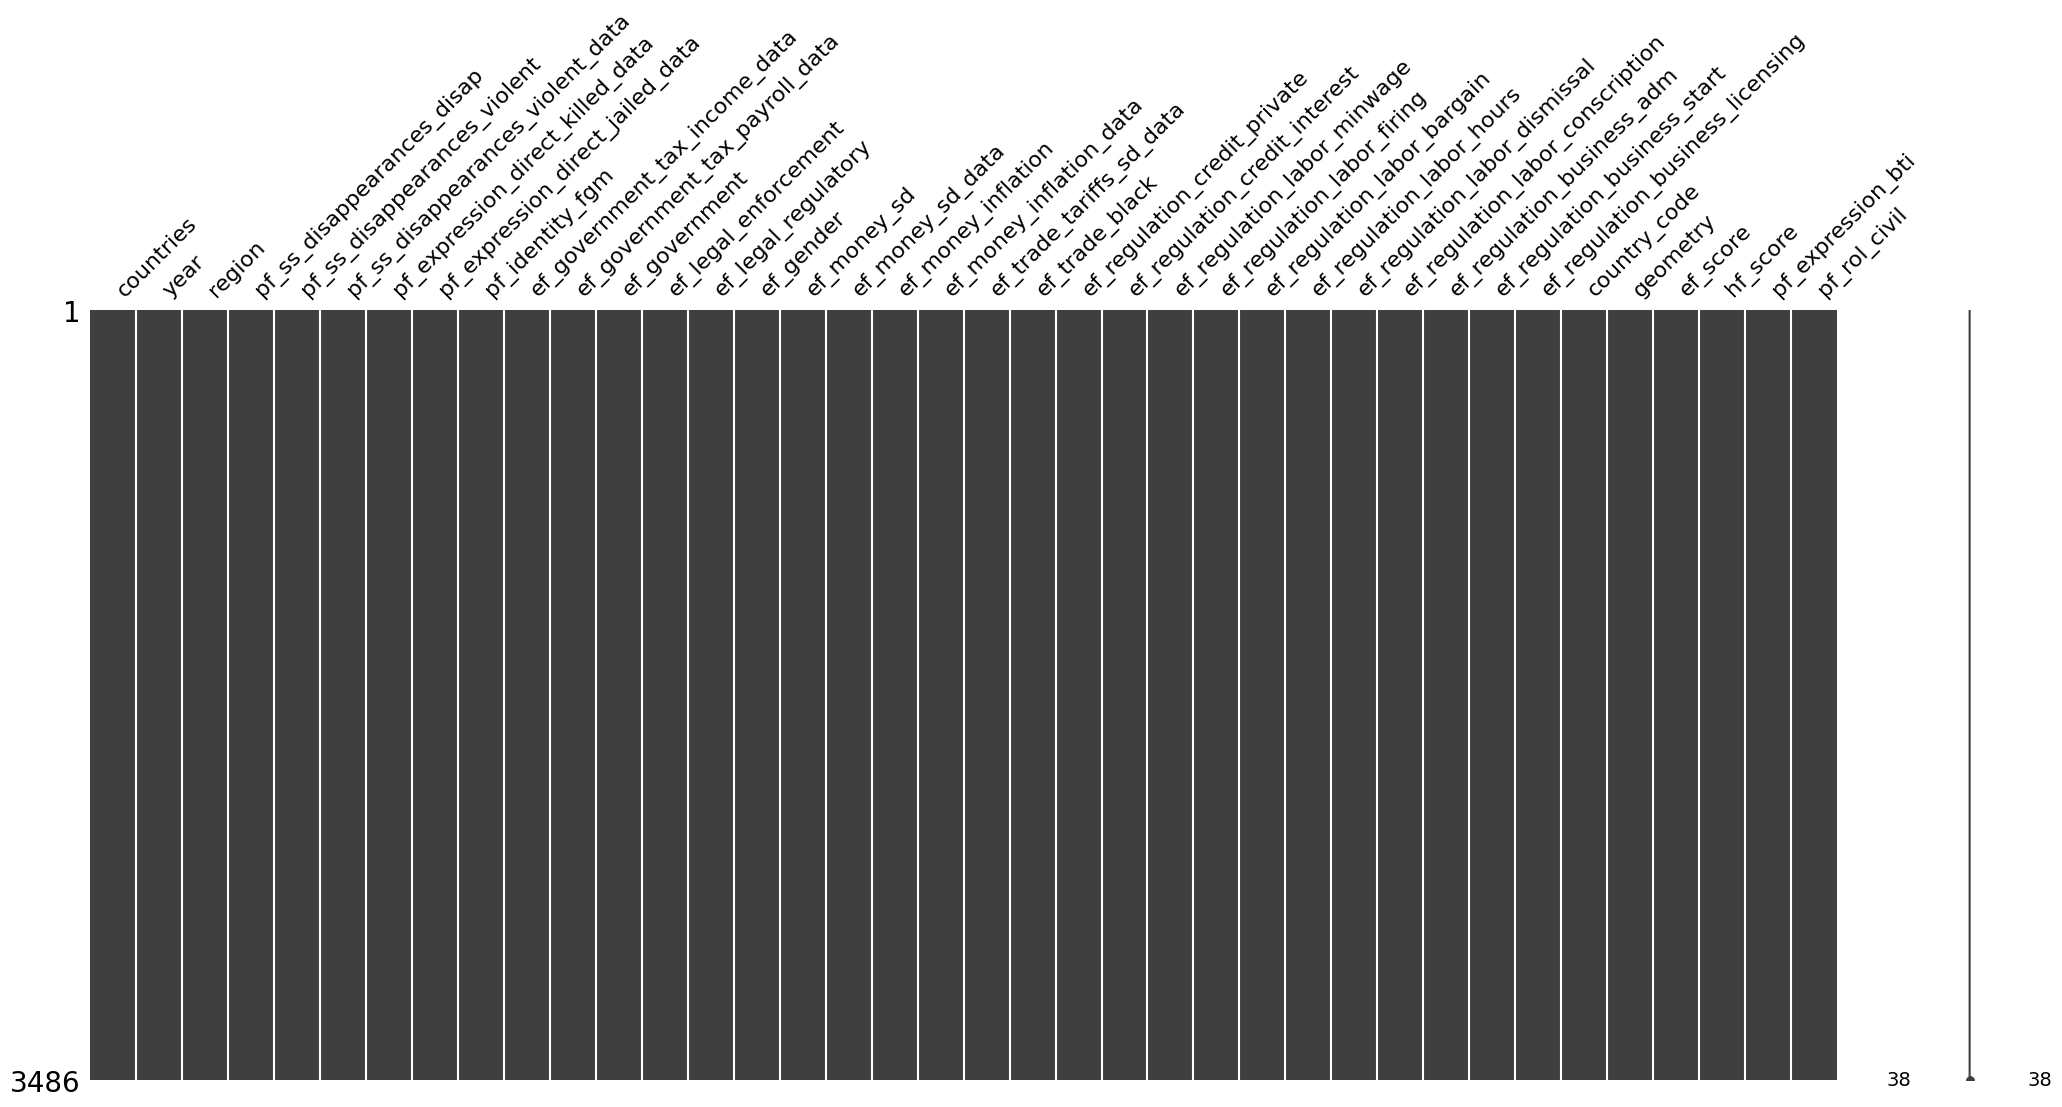

In [791]:
# Inspect the final data frame
msno.matrix(df_result)

In [792]:
df_result.columns

Index(['countries', 'year', 'region', 'pf_ss_disappearances_disap',
       'pf_ss_disappearances_violent', 'pf_ss_disappearances_violent_data',
       'pf_expression_direct_killed_data', 'pf_expression_direct_jailed_data',
       'pf_identity_fgm', 'ef_government_tax_income_data',
       'ef_government_tax_payroll_data', 'ef_government',
       'ef_legal_enforcement', 'ef_legal_regulatory', 'ef_gender',
       'ef_money_sd', 'ef_money_sd_data', 'ef_money_inflation',
       'ef_money_inflation_data', 'ef_trade_tariffs_sd_data', 'ef_trade_black',
       'ef_regulation_credit_private', 'ef_regulation_credit_interest',
       'ef_regulation_labor_minwage', 'ef_regulation_labor_firing',
       'ef_regulation_labor_bargain', 'ef_regulation_labor_hours',
       'ef_regulation_labor_dismissal', 'ef_regulation_labor_conscription',
       'ef_regulation_business_adm', 'ef_regulation_business_start',
       'ef_regulation_business_licensing', 'country_code', 'geometry',
       'ef_score', 'hf_sco

## Encoding categorical variables

In [793]:
# One-hot encode the 'region' columns
region_dummies = pd.get_dummies(df_result['region'], prefix='region')

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df_result, region_dummies], axis=1)

# Display the resulting DataFrame
df_encoded

,countries,year,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_expression_direct_killed_data,pf_expression_direct_jailed_data,pf_identity_fgm,ef_government_tax_income_data,...,region_Caucasus & Central Asia,region_East Asia,region_Eastern Europe,region_Latin America & the Caribbean,region_Middle East & North Africa,region_North America,region_Oceania,region_South Asia,region_Sub-Saharan Africa,region_Western Europe
0,Albania,2020.0,Eastern Europe,10.0,10.000000,0.0,0.0,0.0,10.0,23.0,...,0,0,1,0,0,0,0,0,0,0
1,Algeria,2020.0,Middle East & North Africa,10.0,9.687083,25.0,0.0,8.0,10.0,35.0,...,0,0,0,0,1,0,0,0,0,0
2,Angola,2020.0,Sub-Saharan Africa,10.0,9.582498,25.0,0.0,0.0,10.0,17.0,...,0,0,0,0,0,0,0,0,1,0
3,Argentina,2020.0,Latin America & the Caribbean,5.0,10.000000,0.0,0.0,0.0,10.0,35.0,...,0,0,0,1,0,0,0,0,0,0
4,Armenia,2020.0,Caucasus & Central Asia,10.0,10.000000,0.0,0.0,0.0,10.0,23.0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,Venezuela,2000.0,Latin America & the Caribbean,10.0,10.000000,0.0,0.0,0.0,10.0,35.0,...,0,0,0,1,0,0,0,0,0,0
3482,Vietnam,2000.0,South Asia,10.0,10.000000,0.0,0.0,16.0,10.0,63.0,...,0,0,0,0,0,0,0,1,0,0
3483,Yemen,2000.0,Middle East & North Africa,5.0,10.000000,0.0,0.0,0.0,10.0,15.0,...,0,0,0,0,1,0,0,0,0,0
3484,Zambia,2000.0,Sub-Saharan Africa,10.0,10.000000,0.0,0.0,2.0,10.0,30.0,...,0,0,0,0,0,0,0,0,1,0


In [794]:
df_encoded.geometry

0       POLYGON ((20.07142 42.56091, 20.10208 42.53347...
1       POLYGON ((8.62203 36.94137, 8.63222 36.88194, ...
2       MULTIPOLYGON (((23.98621 -10.87046, 23.98805 -...
3       MULTIPOLYGON (((-68.64312 -54.88861, -68.63723...
4       POLYGON ((46.54038 38.87559, 46.51639 38.87804...
                              ...                        
3481    MULTIPOLYGON (((-61.18507 8.49674, -61.19417 8...
3482    MULTIPOLYGON (((104.08288 10.36486, 104.08663 ...
3483    MULTIPOLYGON (((52.23416 12.20111, 52.27888 12...
3484    POLYGON ((32.94040 -9.40508, 32.93944 -9.41583...
3485    POLYGON ((30.41576 -15.63187, 30.41729 -15.642...
Name: geometry, Length: 3486, dtype: geometry

In [795]:
# Save the DataFrame as a Parquet file
gdf = gpd.GeoDataFrame(df_encoded, geometry='geometry')

# Save the GeoDataFrame as a GeoParquet file
gdf.to_parquet('gdf_engineered.parquet', compression='snappy', index=False)

In [797]:
df_result = df_result.drop(columns=['country_code', 'globalNorth', 'countries', 'geometry'])

In [ ]:
df_result

,year,region,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_violent_data,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_fatalities_data,pf_ss_disappearances_injuries,pf_ss_disappearances_injuries_data,...,ef_regulation_business_burden,ef_regulation_business_start,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,ef_score,hf_score,pf_expression_bti,pf_rol_civil
0,2020.0,Eastern Europe,10.0,10.000000,0.0,7.50,10.000000,0.0,10.000000,0.0,...,6.000000,9.742477,5.621940,7.175250,6.698118,7.112958,0,0,0,0
1,2020.0,Middle East & North Africa,10.0,9.687083,25.0,5.00,10.000000,0.0,10.000000,0.0,...,2.222222,9.305002,8.771111,7.029528,5.686753,5.778953,0,0,0,0
2,2020.0,Sub-Saharan Africa,10.0,9.582498,25.0,7.50,9.736578,5.0,9.971733,1.0,...,3.111111,8.730805,7.916416,6.782923,5.696942,6.227545,0,0,0,0
3,2020.0,Latin America & the Caribbean,5.0,10.000000,0.0,7.50,9.925379,2.0,10.000000,0.0,...,5.555556,9.579288,5.726521,6.508295,6.225232,5.490538,0,0,0,0
4,2020.0,Caucasus & Central Asia,10.0,10.000000,0.0,7.50,10.000000,0.0,10.000000,0.0,...,5.111111,9.863530,9.302574,7.040738,7.124727,7.756333,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3481,2000.0,Latin America & the Caribbean,10.0,10.000000,0.0,10.00,10.000000,0.0,10.000000,0.0,...,6.150000,6.268547,4.529453,0.315142,4.692328,5.531397,0,0,0,1
3482,2000.0,South Asia,10.0,10.000000,0.0,10.00,10.000000,0.0,10.000000,0.0,...,4.500000,7.885638,2.755084,0.000000,3.861879,4.416768,0,0,0,1
3483,2000.0,Middle East & North Africa,5.0,10.000000,0.0,2.50,8.170079,19.0,7.932996,40.0,...,2.121212,8.735527,8.917008,7.220087,5.282343,5.781156,1,1,0,1
3484,2000.0,Sub-Saharan Africa,10.0,10.000000,0.0,10.00,10.000000,0.0,9.827262,2.0,...,3.750000,8.537578,1.776236,8.520369,8.020982,6.799421,0,0,0,1


In [ ]:
df_result.to_parquet('df_imputed', compression='snappy', index=False)